In [1]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time

from matplotlib import pyplot
from matplotlib.patches import Rectangle
##from keras.models import load_model
from tensorflow.keras.models import Model, load_model

import tensorflow.keras as keras

%matplotlib inline
from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


In [2]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
    # Schwarzenegger + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 110
    
    # Learning rate
    LEARNING_RATE=0.0012
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.98
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=1
    # setting Max instances at output
    DETECTION_MAX_INSTANCES = 1
    
    BACKBONE = 'resnet50' ##### CHANGE IT BACK TO RESNET101!  @ 26/03/2020


In [3]:
config = myMaskRCNNConfig()

In [4]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.98
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0012
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTAN

In [5]:
class ArnoldDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "Arnold")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '\\images\\'
        annotations_dir = dataset_dir + '\\annots\\'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # skip bad images
            if image_id in ['00290']: #stam
                continue
            # skip all images after 110 if we are building the train set
            if is_train and int(image_id) >= 111:
                continue
            # skip all images before 110 if we are building the test/val set
            if not is_train and int(image_id) < 111:
                continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height# load the masks for an image
    
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Arnold'))
        return masks, asarray(class_ids, dtype='int32')# load an image reference
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [6]:
train_set = ArnoldDataset()
train_set.load_dataset(r'D:\HIT\DeepLearning\ex3 AND FINAL\Arnold', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 110


In [7]:
test_set = ArnoldDataset()
test_set.load_dataset(r'D:\HIT\DeepLearning\ex3 AND FINAL\Arnold', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 94


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

In [ ]:
model.load_weights('C:\\Users\\User\\Anaconda3\\envs\\MaskRCNN\\mask_rcnn_coco.h5',by_name=True,exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc',  'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
model.train(train_set, test_set,learning_rate=config.LEARNING_RATE, epochs=6, layers='heads') 
history = model.keras_model.history.history


In [ ]:
import time

model_path = 'C:\\Users\\User\\Anaconda3\\envs\\MaskRCNN\\Kangaroo\\kangaroo-master\\mask_rcnn_6Epoch_LR_0_0012_Train110_Va94_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

### ADDITION
#setting Pre trainded Model
model_path = r"C:\Users\User\Anaconda3\envs\MaskRCNN\Kangaroo\kangaroo-master\mask_rcnn_6Epoch_LR_0_0012_Train110_Va94_.1585176647.6981528.h5"
### END ADDITION

#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
imgPath = [r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test01_3Persons.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test02_1Person_1mask.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test03_2Persons_Profile.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test04_1Person_1Robot.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test05_1Person_1nonHuman.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test06.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test07_Expendables_5Persons.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test08_3Persons.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test09_3Persons_oldpic.jpg",
      r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test10_6Persons_fullbody.jpg"]

num = 8
img = load_img(imgPath[num+1])
img = img_to_array(img)
print ("Image loaded: " + imgPath[num+1])

# detecting objects in the image
results= model.detect([img], verbose=1)

Image loaded: D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test10_6Persons_fullbody.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



*** No instances to display *** 



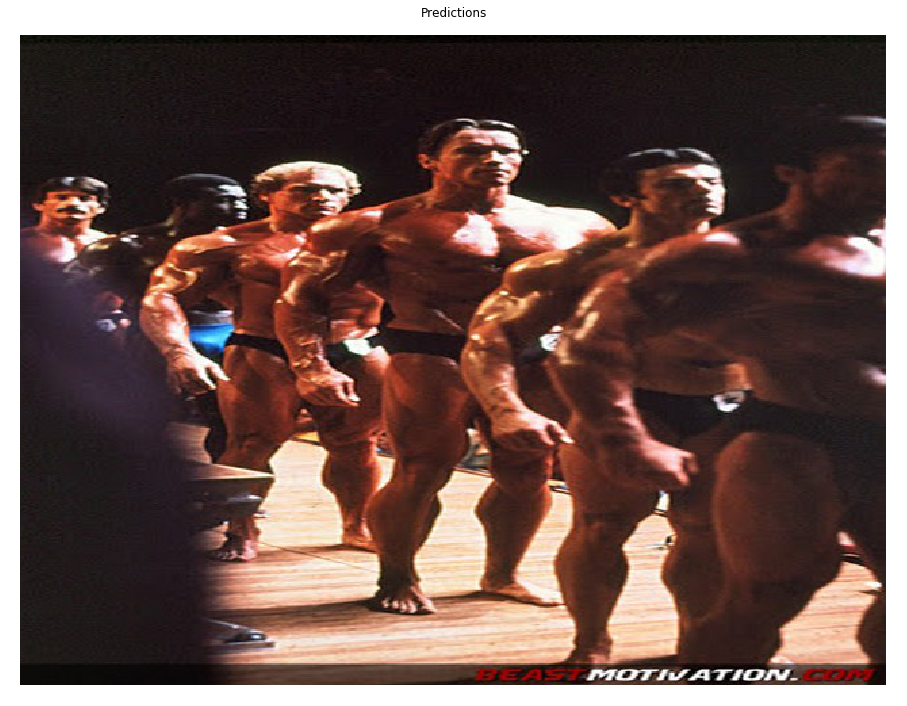

[]


In [9]:
#image_id = 23
#image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
#
#info = test_set.image_info[image_id]
#print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                       test_set.image_reference(image_id)))
#
# Run object detection
#results = model.detect([image], verbose=1)

# Display results

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")
print (r['scores'])

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 1
 
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights(model_path, by_name=True)
# load photograph
img = load_img(r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test04_1Person_1Robot.jpg")
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes(r"D:\HIT\DeepLearning\ex3 AND FINAL\Arnold\TESTING\Resized\test04_1Person_1Robot.jpg", results[0]['rois'])

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.keys())

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

## 